# Building A Book Recommendation System Using Graph Neural Network (GNN) Model

- Create the slide show from this notebook: 

```jupyter nbconvert 'Recommendation System Using LightGCN features.ipynb' --to slides --post serve```

* Use Case: 
    - Recommend books to users of bookcrossing.com website which is a book-sharing community website. 
    
* Data Source: 
    - A collection of book ratings provided by C. Ziegler
    - It's a four-week web crawl data on bookcrossing.com website during August to September in 2004
    - Basic stats: 47k users, 98k books, and 1.1MM user ratings 


In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [19]:
import torch

torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

from PIL import Image
import requests

from torch_geometric.data import HeteroData
from torch_geometric.loader import NeighborSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

from datetime import datetime

from utils import *
from personalization_index import *

# exclude the INFO logs
import logging
import logging

# Set the logging level to WARNING to suppress informational messages
logging.getLogger().setLevel(logging.WARNING)


## 1. Preprocessing the dataset

### Import necessary libraries

In [3]:
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn.functional as F
from torch import nn, optim, Tensor
import torch.sparse as sparse

from torch_geometric.utils import structured_negative_sampling
from torch_geometric.nn.conv.gcn_conv import gcn_norm
from torch_geometric.nn import LGConv

In [4]:
import torch
print(torch.cuda.is_available())  # Should return True if CUDA is available
print(torch.version.cuda)         # Should print the CUDA version PyTorch is built with


False
12.1


In [5]:
# check the available cpu memeory
import psutil
psutil.virtual_memory()

svmem(total=8315170816, available=3298308096, percent=60.3, used=4685344768, free=1358045184, active=959090688, inactive=5372964864, buffers=174116864, cached=2097664000, shared=1359872, slab=410427392)

### Read in the raw data

In [6]:
users_df = pd.read_csv('data/BX-Users.csv', sep=';', encoding='latin-1')
# rename 'Location' and 'Age' to lowercase
users_df.rename(columns={'Location': 'location', 'Age': 'age'}, inplace=True)
# Example age bins
bins = [0, 18, 35, 55, 75, float('inf')]
labels = ['0-18', '19-35', '36-55', '56-75', '76+']

users_df['age'].fillna(users_df['age'].median(), inplace=True)

users_df['age_group'] = pd.cut(users_df['age'], bins=bins, labels=labels, right=False)

# rename 'User-ID' to 'user_id' 
users_df.rename(columns={'User-ID': 'user_id'}, inplace=True)

items_df = pd.read_csv('data/BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')
# rename 'Book-Title' to 'title', 'Book-Author' to 'author'
items_df.rename(columns={'Book-Title': 'title', 'Book-Author': 'author', 'Publisher':'publisher'}, inplace=True)
# rename 'ISBN' to 'item_id'
items_df.rename(columns={'ISBN': 'item_id'}, inplace=True)


/tmp/ipykernel_167320/3616573672.py:15: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  items_df = pd.read_csv('data/BX-Books.csv', sep=';', encoding='latin-1', on_bad_lines='skip')


In [7]:
ratings_df = pd.read_csv('data/BX-Book-Ratings.csv', sep=';', encoding='latin-1')  
# rename 'User-ID' to 'user_id', 'Book-Rating' to 'rating', 'ISBN' to 'item_id'
ratings_df.rename(columns={'User-ID': 'user_id', 'Book-Rating': 'rating', 'ISBN': 'item_id'}, inplace=True)


In [8]:
items_df.head()

,item_id,title,author,Year-Of-Publication,publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [9]:
users_df.head()

,user_id,location,age,age_group
0,1,"nyc, new york, usa",32.0,19-35
1,2,"stockton, california, usa",18.0,19-35
2,3,"moscow, yukon territory, russia",32.0,19-35
3,4,"porto, v.n.gaia, portugal",17.0,0-18
4,5,"farnborough, hants, united kingdom",32.0,19-35


In [10]:
ratings_df.head()

,user_id,item_id,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [11]:
items_df.shape

(271360, 8)

* Missing values check

In [12]:
items_df.isna().sum()

item_id                0
title                  0
author                 2
Year-Of-Publication    0
publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [13]:
items_df['author'] = items_df['author'].fillna('NA')
items_df['publisher'] = items_df['publisher'].fillna('NA')

In [14]:
all_ratings_df = ratings_df.copy()

In [15]:

# Preprocessing
ratings_df = ratings_df.loc[ratings_df['item_id'].isin(items_df['item_id'].unique()) & ratings_df['user_id'].isin(users_df['user_id'].unique())]

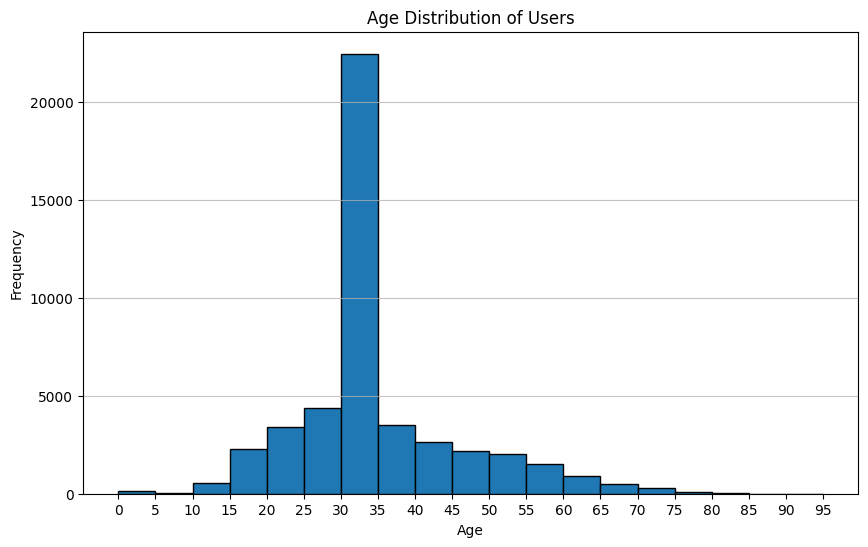

In [16]:
plot_age_distribution()

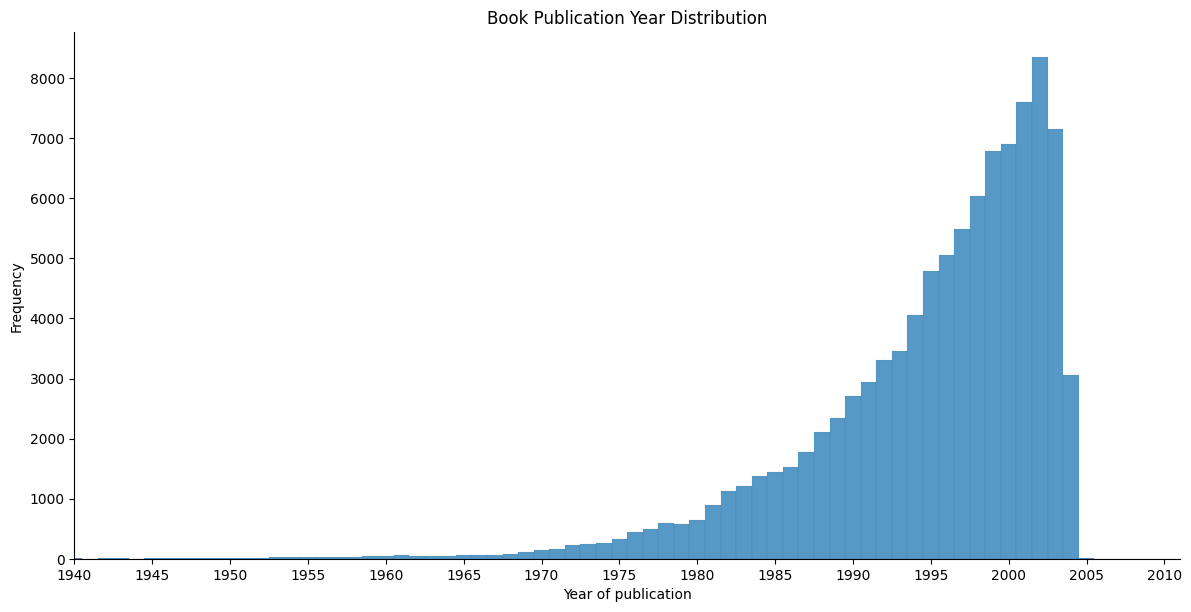

In [17]:
plot_book_year_distribution()

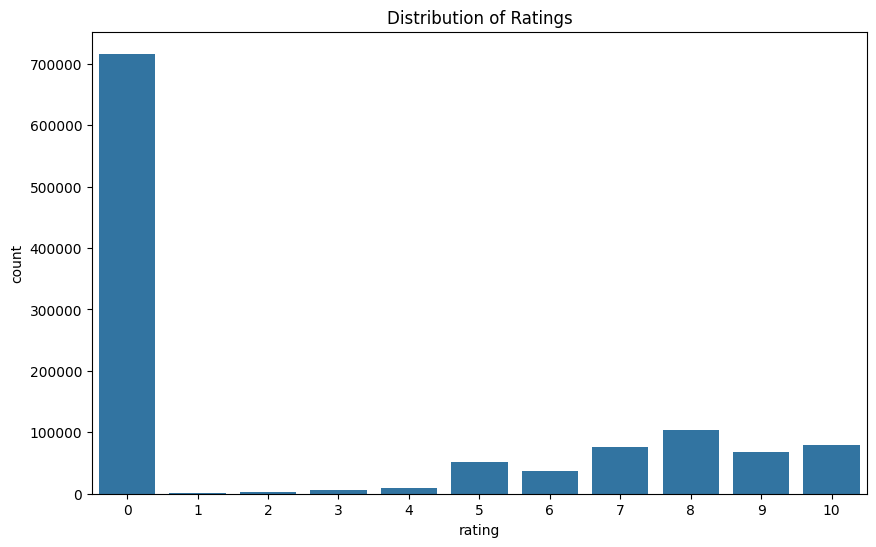

In [20]:
plot_rating_distribution()

### User-Item Graph

In [ ]:
create_user_subgraph(236198)

### Data check

In [21]:

print("full rating dataframe size: ", str(ratings_df.shape))
# # Keep the 100k highest ratings
ratings_df = ratings_df[ratings_df['rating'] >= 8] # .iloc[:100000]
print("subset rating dataframe size: ", str(ratings_df.shape))

# subsert users_df where user_id is in ratings_df
users_df = users_df[users_df['user_id'].isin(ratings_df['user_id'].unique())].copy()
# subsert items_df where item_id is in ratings_df
items_df = items_df[items_df['item_id'].isin(ratings_df['item_id'].unique())].copy()

print(users_df.shape)
print(items_df.shape)

full rating dataframe size:  (1031136, 3)
subset rating dataframe size:  (223807, 3)
(47074, 4)
(98417, 8)


## Feature Engineering

In [22]:
# Create mappings
user_mapping = {userid: i for i, userid in enumerate(users_df['user_id'].unique())}
item_mapping = {isbn: i for i, isbn in enumerate(items_df['item_id'].unique())}

# Count users and items
num_users = len(user_mapping)
num_items = len(item_mapping)
num_total = num_users + num_items

# Map user and item indices
users_df['user_idx'] = users_df['user_id'].map(user_mapping)
items_df['item_idx'] = items_df['item_id'].map(item_mapping)
ratings_df['user_idx'] = ratings_df['user_id'].map(user_mapping)
ratings_df['item_idx'] = ratings_df['item_id'].map(item_mapping)


In [23]:
user_mapping[16]

1

In [24]:
import pickle

# Save user_mapping
with open('models/user_mapping.pkl', 'wb') as f:
    pickle.dump(user_mapping, f)

# Save item_mapping
with open('models/item_mapping.pkl', 'wb') as f:
    pickle.dump(item_mapping, f)


In [25]:
ratings_df.item_idx.min()

0

In [26]:
items_df.columns

Index(['item_id', 'title', 'author', 'Year-Of-Publication', 'publisher',
       'Image-URL-S', 'Image-URL-M', 'Image-URL-L', 'item_idx'],
      dtype='object')

### Transforming the user features and item features

In [27]:
# # fill missing values of locations, age_group, subject, author with 'unknown'
# def fillna_category(df, column):
#     df[column] = df[column].astype('category')
#     df[column].cat.add_categories('unknown')
#     df[column].fillna('unknown', inplace=True)

# check if there are any missing values
items_df.isna().sum()

# delete rows with missing values in 'title' and 'author'
# items_df.dropna(subset=['title', 'author'], inplace=True)


item_id                0
title                  0
author                 0
Year-Of-Publication    0
publisher              0
Image-URL-S            0
Image-URL-M            0
Image-URL-L            0
item_idx               0
dtype: int64

In [28]:
# Function to map categories to indices
def map_categories(df, column):
    unique_values = df[column].unique()
    value_to_idx = {value: idx for idx, value in enumerate(unique_values)}
    return df[column].map(value_to_idx), len(unique_values)

# Map each categorical feature
users_df['location_idx'], num_locations = map_categories(users_df, 'location')
users_df['age_group_idx'], num_age_groups = map_categories(users_df, 'age_group')
items_df['subject_idx'], num_subjects = map_categories(items_df, 'publisher')
items_df['author_idx'], num_authors = map_categories(items_df, 'author')

### Prepare Graph-Structured Data for the Neural Network Model

In [29]:
# Convert indices to tensors
user_location_indices = torch.tensor(users_df['location_idx'].values, dtype=torch.long)
user_age_group_indices = torch.tensor(users_df['age_group_idx'].values, dtype=torch.long)
item_subject_indices = torch.tensor(items_df['subject_idx'].values, dtype=torch.long)
item_author_indices = torch.tensor(items_df['author_idx'].values, dtype=torch.long)


In [30]:
# Initialize HeteroData
data = HeteroData()

# Assigning integer-encoded features
data['user'].x = torch.cat([user_location_indices.unsqueeze(1), user_age_group_indices.unsqueeze(1)], dim=1)
data['item'].x = torch.cat([item_subject_indices.unsqueeze(1), item_author_indices.unsqueeze(1)], dim=1)

# Creating edge index from ratings dataframe
edge_index = torch.tensor(ratings_df[['user_idx', 'item_idx']].values.T, dtype=torch.long)
edge_features = torch.tensor(ratings_df['rating'].values, dtype=torch.float)
# Create edge labels based on the rating
edge_labels = (edge_features >= 8).long()  # This will create a tensor of 0s and 1s

# Assign edge features (ratings), edge type = 'Rating Edge'
data['user', 'Rating Edge', 'item'].edge_index = edge_index
data['user', 'Rating Edge', 'item'].edge_attr = edge_features
# Assign edge labels to the HeteroData object
data['user', 'Rating Edge', 'item'].edge_label = edge_labels
# Assign edge label indices (in this case, they are the same as edge indices)
data['user', 'Rating Edge', 'item'].edge_label_index = edge_index


In [31]:
edge_labels

tensor([1, 1, 1,  ..., 1, 1, 1])

In [32]:
data

HeteroData(
  user={ x=[47074, 2] },
  item={ x=[98417, 2] },
  (user, Rating Edge, item)={
    edge_index=[2, 223807],
    edge_attr=[223807],
    edge_label=[223807],
    edge_label_index=[2, 223807],
  }
)

In [29]:
# pickle the data
with open('data/hetero_graph_data.pkl', 'wb') as f:
    pickle.dump(data, f)

In [30]:
# Load the data
with open('data/hetero_graph_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [33]:
import pandas as pd

# Assuming ratings_df, users_df, and items_df are your DataFrames

# 1. Check for Invalid or Missing Values in ratings_df
if ratings_df.isnull().values.any():
    print("There are missing values in ratings_df.")
else:
    print("No missing values in ratings_df.")

# 2. Verify User and Item Index Alignment
max_user_idx = ratings_df['user_idx'].max()
max_item_idx = ratings_df['item_idx'].max()

if max_user_idx >= len(users_df) or max_item_idx >= len(items_df):
    print("User or Item indices in ratings_df exceed the number of rows in users_df or items_df.")
else:
    print("User and Item indices in ratings_df are correctly aligned.")

# 3. Check for Duplicate Rows
if ratings_df.duplicated(subset=['user_idx', 'item_idx']).any():
    print("There are duplicate user-item pairs in ratings_df.")
else:
    print("No duplicate user-item pairs in ratings_df.")

# 4. Inspect Index Continuity
user_idx_continuous = set(ratings_df['user_idx']) == set(range(max_user_idx + 1))
item_idx_continuous = set(ratings_df['item_idx']) == set(range(max_item_idx + 1))

if not user_idx_continuous or not item_idx_continuous:
    print("User or Item indices in ratings_df are not continuous.")
else:
    print("User and Item indices in ratings_df are continuous.")


No missing values in ratings_df.
User and Item indices in ratings_df are correctly aligned.
No duplicate user-item pairs in ratings_df.
User and Item indices in ratings_df are continuous.


In [34]:
# Assuming edge_labels is a tensor of edge labels

# Number of edges in ratings_df
num_edges_in_df = ratings_df.shape[0]

# Number of labels in edge_labels
num_labels = edge_labels.shape[0]

# Check if every edge has a corresponding label
if num_edges_in_df == num_labels:
    print("Every edge has a corresponding label.")
else:
    print(f"Mismatch: {num_edges_in_df} edges in DataFrame, but {num_labels} labels.")


Every edge has a corresponding label.


In [35]:
# Check if indices start from 0 and are continuous

# Check for user indices
min_user_idx = ratings_df['user_idx'].min()
max_user_idx = ratings_df['user_idx'].max()
user_indices_continuous = set(ratings_df['user_idx']) == set(range(min_user_idx, max_user_idx + 1))

# Check for item indices
min_item_idx = ratings_df['item_idx'].min()
max_item_idx = ratings_df['item_idx'].max()
item_indices_continuous = set(ratings_df['item_idx']) == set(range(min_item_idx, max_item_idx + 1))

# Print the results
if min_user_idx != 0 or not user_indices_continuous:
    print("User indices are either not starting from 0 or not continuous.")
else:
    print("User indices start from 0 and are continuous.")

if min_item_idx != 0 or not item_indices_continuous:
    print("Item indices are either not starting from 0 or not continuous.")
else:
    print("Item indices start from 0 and are continuous.")


User indices start from 0 and are continuous.
Item indices start from 0 and are continuous.


## 2. Train-Validation-Test Data split

- We split the data into Training-validation-testing data by 80:10:10.

In [36]:
def create_data_subset(source_data, edge_index, edge_attr, edge_label_index, edge_label):
    """
    Creates a subset of graph data from a source heterogeneous graph.

    This function constructs a new HeteroData object (a heterogeneous graph representation) 
    by selecting specific edges and their attributes from the source data. It's typically 
    used in graph neural network tasks to create subsets of data for training, validation, 
    or testing. The function assumes the graph has a bipartite structure with 'user' and 
    'item' node types and edges representing 'Rating Edge'.

    Parameters:
    source_data (HeteroData): The source heterogeneous graph data from which the subset is created.
                              This should be an instance of HeteroData with 'user' and 'item' node types.
    edge_index (Tensor): A 2xN tensor specifying the edges in the subset. Each column is an edge
                         in the format [source, target], typically representing a 'user'-'item' interaction.
    edge_attr (Tensor): A tensor containing attributes for each edge specified in edge_index.
    edge_label_index (Tensor): A 2xM tensor specifying the edges for which labels are provided.
                               This is typically a subset or the same as edge_index.
    edge_label (Tensor): A tensor containing labels for each edge specified in edge_label_index.

    Returns:
    HeteroData: A new HeteroData object representing the subset of the original graph. This subset
                includes node features for 'user' and 'item' types and the specified edges with their
                attributes and labels.
    """
    subset = HeteroData()
    subset['user'].x = source_data['user'].x
    subset['item'].x = source_data['item'].x
    subset['user', 'Rating Edge', 'item'].edge_index = edge_index
    subset['user', 'Rating Edge', 'item'].edge_attr = edge_attr
    subset['user', 'Rating Edge', 'item'].edge_label_index = edge_label_index
    subset['user', 'Rating Edge', 'item'].edge_label = edge_label
    return subset


In [37]:
def split_edges(edge_index, edge_attr, edge_label_index, edge_label, proportions=(0.8, 0.1, 0.1)):
    """
    Splits the edges of a graph into training, validation, and test sets.

    This function shuffles and divides the edges of a graph into three subsets based on
    the specified proportions. It is useful for preparing graph data for machine learning tasks,
    ensuring distinct edge sets for training, validation, and testing phases.

    Parameters:
    edge_index (Tensor): A 2xN tensor with each column representing an edge as [source, target].
    edge_attr (Tensor): Attributes associated with each edge in edge_index.
    edge_label_index (Tensor): A 2xN tensor specifying the edges for which labels are provided.
    edge_label (Tensor): Labels for each edge specified in edge_label_index.
    proportions (tuple of float, optional): The proportions to split the edges into training,
                                            validation, and test sets. Defaults to (0.8, 0.1, 0.1).

    Returns:
    tuple: Three tuples corresponding to the training, validation, and test sets. Each tuple contains
           the edge_index, edge_attr, edge_label_index, and edge_label for that subset.
    """
    num_edges = edge_index.size(1)
    all_indices = torch.randperm(num_edges)

    train_size = int(proportions[0] * num_edges)
    val_size = int(proportions[1] * num_edges)

    train_indices = all_indices[:train_size]
    val_indices = all_indices[train_size:train_size + val_size]
    test_indices = all_indices[train_size + val_size:]

    return ((edge_index[:, train_indices], edge_attr[train_indices],
             edge_label_index[:, train_indices], edge_label[train_indices]),
            (edge_index[:, val_indices], edge_attr[val_indices],
             edge_label_index[:, val_indices], edge_label[val_indices]),
            (edge_index[:, test_indices], edge_attr[test_indices],
             edge_label_index[:, test_indices], edge_label[test_indices]))


In [38]:

# Apply the split
train_split, val_split, test_split = split_edges(
    data['user', 'Rating Edge', 'item'].edge_index, 
    data['user', 'Rating Edge', 'item'].edge_attr,
    data['user', 'Rating Edge', 'item'].edge_label_index,
    data['user', 'Rating Edge', 'item'].edge_label
)


In [39]:

# Create subsets
train_data = create_data_subset(data, *train_split)
val_data = create_data_subset(data, *val_split)
test_data = create_data_subset(data, *test_split)


In [40]:
train_data

HeteroData(
  user={ x=[47074, 2] },
  item={ x=[98417, 2] },
  (user, Rating Edge, item)={
    edge_index=[2, 179045],
    edge_attr=[179045],
    edge_label_index=[2, 179045],
    edge_label=[179045],
  }
)

In [41]:
val_data

HeteroData(
  user={ x=[47074, 2] },
  item={ x=[98417, 2] },
  (user, Rating Edge, item)={
    edge_index=[2, 22380],
    edge_attr=[22380],
    edge_label_index=[2, 22380],
    edge_label=[22380],
  }
)

## 3. Mini-Batch Creation with Graph Dataloader

Key benefits of mini-batch approach:

* Efficient Memory Utilization
* Parallel processing and scalability
* Flexible graph sampling
* Improved learning on imbalanced datasets

## Custom Graph Data Loader

In [42]:
import random
import torch
from torch.utils.data import Dataset, DataLoader

class CustomGraphDataset(Dataset):
    def __init__(self, data):
        self.edge_index = data['user', 'Rating Edge', 'item'].edge_index
        self.num_users = data['user'].x.size(0)
        self.num_items = data['item'].x.size(0)
        self.positive_pairs = set(zip(self.edge_index[0].tolist(), self.edge_index[1].tolist()))

    def __len__(self):
        return self.edge_index.size(1)

    def __getitem__(self, idx):
        user_idx = self.edge_index[0, idx]
        item_idx = self.edge_index[1, idx]

        # Generate a negative sample
        neg_item_idx = random.randint(0, self.num_items - 1)
        while (user_idx, neg_item_idx) in self.positive_pairs:
            neg_item_idx = random.randint(0, self.num_items - 1)

        return user_idx, item_idx, neg_item_idx

def custom_collate_fn(batch):
    user_indices, pos_item_indices, neg_item_indices = zip(*batch)
    return {
        'user_indices': torch.tensor(user_indices, dtype=torch.long),
        'pos_item_indices': torch.tensor(pos_item_indices, dtype=torch.long),
        'neg_item_indices': torch.tensor(neg_item_indices, dtype=torch.long)
    }

def create_custom_loader(data, batch_size=128, shuffle=True):
    dataset = CustomGraphDataset(data)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, collate_fn=custom_collate_fn)


In [43]:
data['item'].x.size(0)

98417

In [44]:
train_loader = create_custom_loader(train_data, batch_size=64, shuffle=True)
val_loader = create_custom_loader(val_data, batch_size=64, shuffle=False)
test_loader = create_custom_loader(test_data, batch_size=64, shuffle=False)

In [45]:
test_data

HeteroData(
  user={ x=[47074, 2] },
  item={ x=[98417, 2] },
  (user, Rating Edge, item)={
    edge_index=[2, 22382],
    edge_attr=[22382],
    edge_label_index=[2, 22382],
    edge_label=[22382],
  }
)

## 4. Define the GNN Model architecture

* Tailored to specific problems
* Incorporation of domain knowledge
* Better generalization and scalability
* Experimentation and innovation for model performance

In [46]:
import torch
import torch.nn as nn
from torch.sparse import mm as sparse_mm

class LightGCN(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, num_layers,
                 num_locations, num_age_groups, num_subjects, num_authors):
        super(LightGCN, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_dim = embedding_dim
        self.num_layers = num_layers

        # Initialize user and item embeddings
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)

        # Initialize additional feature embeddings
        self.location_embedding = nn.Embedding(num_locations, embedding_dim)
        self.age_group_embedding = nn.Embedding(num_age_groups, embedding_dim)
        self.subject_embedding = nn.Embedding(num_subjects, embedding_dim)
        self.author_embedding = nn.Embedding(num_authors, embedding_dim)

        # Initialization
        nn.init.normal_(self.user_embedding.weight, std=0.1)
        nn.init.normal_(self.item_embedding.weight, std=0.1)
        nn.init.normal_(self.location_embedding.weight, std=0.1)
        nn.init.normal_(self.age_group_embedding.weight, std=0.1)
        nn.init.normal_(self.subject_embedding.weight, std=0.1)
        nn.init.normal_(self.author_embedding.weight, std=0.1)


In [ ]:

    def forward(self, user_indices, item_indices, location_indices, age_group_indices, subject_indices, author_indices, adj_matrix):
        # Initial user and item embeddings
        user_emb = self.user_embedding(user_indices)
        item_emb = self.item_embedding(item_indices)

        # Embeddings for additional features
        location_emb = self.location_embedding(location_indices)
        age_group_emb = self.age_group_embedding(age_group_indices)
        subject_emb = self.subject_embedding(subject_indices)
        author_emb = self.author_embedding(author_indices)

        # Combine base embeddings with feature embeddings
        user_emb = user_emb + location_emb + age_group_emb
        item_emb = item_emb + subject_emb + author_emb

        # Debug: Print dimensions for troubleshooting
        print("Adjacency Matrix Shape:", adj_matrix.shape)
        print("User Embeddings Shape:", user_emb.shape)
        print("Item Embeddings Shape:", item_emb.shape)

        all_embeddings = torch.cat([user_emb, item_emb], dim=0)

        print("All Embeddings Shape:", all_embeddings.shape)

        # List to hold all embeddings for each layer
        all_user_embs = [user_emb]
        all_item_embs = [item_emb]

        # Perform graph convolutions
        for _ in range(self.num_layers):
            # Ensure dimensions are compatible for matrix multiplication
            if adj_matrix.shape[0] != all_embeddings.shape[0]:
                raise ValueError("Dimension mismatch: adj_matrix and all_embeddings must have the same number of rows")

            all_embeddings = sparse_mm(adj_matrix, all_embeddings)

            user_emb = all_embeddings[:self.num_users]
            item_emb = all_embeddings[self.num_users:]

            all_user_embs.append(user_emb)
            all_item_embs.append(item_emb)

        # Compute final embeddings as the mean of all layers' embeddings
        final_user_emb = torch.mean(torch.stack(all_user_embs), dim=0)
        final_item_emb = torch.mean(torch.stack(all_item_embs), dim=0)

        # Predict ratings by computing the dot product of user and item embeddings
        scores = torch.sum(final_user_emb * final_item_emb, dim=1)

        # self.cached_embeddings = all_embeddings  # Cache the embeddings

        return scores
    
    def get_user_embeddings(self, user_indices):
        user_emb = self.user_embedding(user_indices)
        # You can add additional features if necessary
        return user_emb

    def get_item_embeddings(self, item_indices):
        # Print the item indices for debugging
        # print("Item Indices:", item_indices)
        item_emb = self.item_embedding(item_indices)
        # You can add additional features if necessary
        return item_emb

    

# Example usage:
# model = LightGCN(num_users=1000, num_items=500, embedding_dim=64, num_layers=3,
#                  num_locations=10, num_age_groups=5, num_subjects=20, num_authors=50)
# ... (setup data and training loop) ...


* When computing the logarithm of the sigmoid function, there's a risk of numerical instability, especially when the argument of the sigmoid function (pos_scores - neg_scores) takes large positive or negative values. In these cases, the sigmoid function can return values very close to 0 or 1, leading to issues when taking the logarithm (since log(0) is undefined and can lead to nan values).
* 
To enhance the stability, you can use the torch.nn.functional.logsigmoid function, which is a numerically stable version of the logarithm of the sigmoid function.

## 5. Model Training and Validation

In [46]:
# Number of unique locations
num_locations = data['user'].x[:, 0].unique().size(0)
# Number of unique age groups
num_age_groups = data['user'].x[:, 1].unique().size(0)

# Number of unique subjects
num_subjects = data['item'].x[:, 0].unique().size(0)
# Number of unique authors
num_authors = data['item'].x[:, 1].unique().size(0)
# Number of unique users
num_users = data['user', 'Rating Edge', 'item'].edge_index[0].unique().size(0)
# Number of unique items
num_items = data['user', 'Rating Edge', 'item'].edge_index[1].unique().size(0)

print("Number of locations:", num_locations)
print("Number of age groups:", num_age_groups)
print("Number of subjects:", num_subjects)
print("Number of authors:", num_authors)
print("Number of users:", num_users)
print("Number of items:", num_items)


Number of locations: 14239
Number of age groups: 5
Number of subjects: 8751
Number of authors: 42696
Number of users: 47074
Number of items: 98417


### Define the Optimizer and Loss Function

In [47]:
import torch.optim as optim

# Define your loss function (assuming BPR loss)
def bpr_loss(users_emb, pos_items_emb, neg_items_emb):
    """
    Bayesian Personalized Ranking (BPR) loss using log sigmoid.
    
    Args:
        users_emb (Tensor): Embeddings of users.
        pos_items_emb (Tensor): Embeddings of positive items.
        neg_items_emb (Tensor): Embeddings of negative items.

    Returns:
        Tensor: BPR loss.
    """
    pos_scores = (users_emb * pos_items_emb).sum(dim=1)
    neg_scores = (users_emb * neg_items_emb).sum(dim=1)
    scores = pos_scores - neg_scores

    # Debugging: Check the range of scores
    # print("Max score:", scores.max().item(), "Min score:", scores.min().item())

    loss = -torch.mean(torch.nn.functional.logsigmoid(scores))
    return loss

## Custom Training Loop

In [48]:
def train(model, train_loader, optimizer):
    model.train()  # Set the model to training mode
    total_loss = 0.0

    for batch in train_loader:
        optimizer.zero_grad()

        user_indices = batch['user_indices']
        pos_item_indices = batch['pos_item_indices']
        neg_item_indices = batch['neg_item_indices']

        # Get embeddings
        users_emb = model.get_user_embeddings(user_indices)
        pos_items_emb = model.get_item_embeddings(pos_item_indices)
        neg_items_emb = model.get_item_embeddings(neg_item_indices)

        # Compute BPR loss
        loss = bpr_loss(users_emb, pos_items_emb, neg_items_emb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(train_loader)

def validate(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            user_indices = batch['user_indices']
            pos_item_indices = batch['pos_item_indices']
            neg_item_indices = batch['neg_item_indices']

            # Get embeddings
            users_emb = model.get_user_embeddings(user_indices)
            pos_items_emb = model.get_item_embeddings(pos_item_indices)
            neg_items_emb = model.get_item_embeddings(neg_item_indices)

            # Compute BPR loss
            loss = bpr_loss(users_emb, pos_items_emb, neg_items_emb)
            total_loss += loss.item()

    return total_loss / len(val_loader)

def test(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0

    with torch.no_grad():
        for batch in test_loader:
            user_indices = batch['user_indices']
            pos_item_indices = batch['pos_item_indices']
            neg_item_indices = batch['neg_item_indices']

            # Get embeddings
            users_emb = model.get_user_embeddings(user_indices)
            pos_items_emb = model.get_item_embeddings(pos_item_indices)
            neg_items_emb = model.get_item_embeddings(neg_item_indices)

            # Compute BPR loss
            loss = bpr_loss(users_emb, pos_items_emb, neg_items_emb)
            total_loss += loss.item()

    return total_loss / len(test_loader)


In [49]:
import torch
import torch.optim as optim

# Assuming the LightGCN model is defined as LightGCN
model = LightGCN(num_users=num_users, 
                 num_items=num_items, 
                 embedding_dim=64,  # Example embedding dimension
                 num_layers=3,      # Example number of layers
                 num_locations=num_locations, 
                 num_age_groups=num_age_groups, 
                 num_subjects=num_subjects, 
                 num_authors=num_authors)

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)


In [ ]:

# Assuming model, train_loader, val_loader, and optimizer are already defined
num_epochs = 10

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer)
    val_loss = validate(model, val_loader)
    test_loss = test(model, test_loader)

    print(f"Epoch {epoch+1}/{num_epochs} - Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Test Loss: {test_loss:.4f}")
    
# save the model
torch.save(model.state_dict(), 'models/lightgcn_model_with_features.pt')    


In [78]:
def calculate_recall_at_k(model, test_loader, k=10):
    total_recall = 0
    num_users = 0

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculations for efficiency
        for batch_data in test_loader:
            user_indices = batch_data['user_indices']
            pos_item_indices = batch_data['pos_item_indices']

            # Generate predictions for all items for each user
            user_emb = model.get_user_embeddings(user_indices)
            all_item_emb = model.get_item_embeddings(torch.arange(model.num_items))
            scores = torch.matmul(user_emb, all_item_emb.T)

            # Rank the items for each user
            _, top_k_indices = torch.topk(scores, k, dim=1)

            for idx, user in enumerate(user_indices):
                # Get the positive item for this user
                pos_item = pos_item_indices[idx]

                # Check if the positive item is in the top k recommendations
                recommended_items = top_k_indices[idx]
                hit = 1 if pos_item in recommended_items else 0

                # Calculate recall for this user
                total_recall += hit
                num_users += 1

    # Calculate average recall@k
    avg_recall = total_recall / num_users if num_users > 0 else 0
    return avg_recall*100

# Example usage
avg_recall = calculate_recall_at_k(model, test_loader, k=20)


In [79]:
# display avg_recall_at_10 in 4 decimal places
print(f"Average Recall@10: {avg_recall:.5f}")

Average Recall@10: 0.01340


## 6. Model Deployment

### 6.1 Batch Recommendations

In [54]:
# Number of unique locations
num_locations = data['user'].x[:, 0].unique().size(0)
# Number of unique age groups
num_age_groups = data['user'].x[:, 1].unique().size(0)

# Number of unique subjects
num_subjects = data['item'].x[:, 0].unique().size(0)
# Number of unique authors
num_authors = data['item'].x[:, 1].unique().size(0)
# Number of unique users
num_users = data['user', 'Rating Edge', 'item'].edge_index[0].unique().size(0)
# Number of unique items
num_items = data['user', 'Rating Edge', 'item'].edge_index[1].unique().size(0)

print("Number of locations:", num_locations)
print("Number of age groups:", num_age_groups)
print("Number of subjects:", num_subjects)
print("Number of authors:", num_authors)
print("Number of users:", num_users)
print("Number of items:", num_items)


Number of locations: 14239
Number of age groups: 5
Number of subjects: 8751
Number of authors: 42696
Number of users: 47074
Number of items: 98417


In [55]:
# Assuming the LightGCN class and other parameters (like num_users, num_items, etc.) are defined
model = LightGCN(num_users=num_users, 
                 num_items=num_items, 
                 embedding_dim=64, 
                 num_layers=3, 
                 num_locations=num_locations, 
                 num_age_groups=num_age_groups, 
                 num_subjects=num_subjects, 
                 num_authors=num_authors)

model.load_state_dict(torch.load('models/lightgcn_model_with_features.pt'))
model.eval()


LightGCN(
  (user_embedding): Embedding(47074, 64)
  (item_embedding): Embedding(98417, 64)
  (location_embedding): Embedding(14239, 64)
  (age_group_embedding): Embedding(5, 64)
  (subject_embedding): Embedding(8751, 64)
  (author_embedding): Embedding(42696, 64)
)

In [56]:
def score_all_items_batched(model, num_users, num_items, batch_size=1000):
    all_scores = torch.zeros(num_users, num_items)

    # Iterate over users in batches
    for user_batch_start in range(0, num_users, batch_size):
        user_batch_end = min(user_batch_start + batch_size, num_users)
        user_indices = torch.arange(user_batch_start, user_batch_end)
        user_embeddings = model.get_user_embeddings(user_indices)

        # Iterate over items in batches
        for item_batch_start in range(0, num_items, batch_size):
            item_batch_end = min(item_batch_start + batch_size, num_items)
            item_indices = torch.arange(item_batch_start, item_batch_end)
            item_embeddings = model.get_item_embeddings(item_indices)

            # Compute scores for the current batch
            batch_scores = torch.mm(user_embeddings, item_embeddings.t())
            all_scores[user_batch_start:user_batch_end, item_batch_start:item_batch_end] = batch_scores

    return all_scores

def exclude_interacted_items(scores, interaction_history):
    for user_id in range(scores.size(0)):
        interacted_items = interaction_history.get(user_id, [])
        scores[user_id, interacted_items] = -float('inf')
    return scores

def get_top_k_recommendations(scores, k=5):
    top_k_items = torch.topk(scores, k, dim=1).indices
    return top_k_items

def get_interaction_history(data):
    interaction_history = {}

    edge_index = data['user', 'Rating Edge', 'item'].edge_index

    # Iterate over all interactions (both positive and negative)
    for index in range(edge_index.size(1)):  # Iterate over the number of edges
        user_id = edge_index[0, index].item()
        item_id = edge_index[1, index].item()

        if user_id not in interaction_history:
            interaction_history[user_id] = []
        interaction_history[user_id].append(item_id)

    return interaction_history


In [57]:
model.get_item_embeddings(torch.tensor([97821]))

tensor([[-0.0166, -0.0098,  0.0074, -0.0129, -0.0129, -0.0102, -0.0123, -0.0071,
         -0.0151,  0.0014,  0.0145, -0.0112,  0.0031,  0.0107, -0.0128, -0.0131,
         -0.0117,  0.0006,  0.0043, -0.0142,  0.0132, -0.0070,  0.0146,  0.0092,
          0.0049,  0.0031, -0.0029, -0.0129,  0.0067, -0.0031,  0.0085,  0.0110,
          0.0032, -0.0106,  0.0108, -0.0140, -0.0127,  0.0075,  0.0103, -0.0094,
          0.0031, -0.0084, -0.0114,  0.0045,  0.0152, -0.0082,  0.0077, -0.0112,
         -0.0025, -0.0124,  0.0076, -0.0142, -0.0075, -0.0049,  0.0135,  0.0074,
          0.0132,  0.0105,  0.0121, -0.0140, -0.0013, -0.0017, -0.0051, -0.0141]],
       grad_fn=<EmbeddingBackward0>)

In [ ]:

interaction_history = get_interaction_history(data)

# Score all items for each user
all_scores = score_all_items_batched(model, num_users, num_items,  batch_size=500)

# Exclude already interacted items
scores = exclude_interacted_items(all_scores, interaction_history)

# Get top-5 recommendations
top_5_recommendations = get_top_k_recommendations(scores, k=5)

# Display the recommendations
for user_id in range(10):  # Modify as needed for your specific use case
    print(f"User {user_id}: {top_5_recommendations[user_id]}")

# save top_5_recommendations to a pands dataframe and a csv file
top_5_recommendations_df = pd.DataFrame(top_5_recommendations)
top_5_recommendations_df.to_csv('data/top_5_recommendations.csv', index=False)


In [55]:
top_5_recommendations_df = pd.read_csv('data/top_5_recommendations.csv')


In [56]:
top_5_recommendations_df.head()

,0,1,2,3,4
0,5915,43562,57125,2292,24594
1,309,557,380,1618,274
2,309,557,380,1618,274
3,1618,2591,4621,5021,3987
4,309,557,380,274,1618


In [57]:
top_5_recommendations_df.columns = ['item1', 'item2', 'item3', 'item4', 'item5']
# turn index into user_idx column in top_5_recommendations_df
top_5_recommendations_df['user_idx'] = top_5_recommendations_df.index


In [58]:
top_5_recommendations_df.head()

,item1,item2,item3,item4,item5,user_idx
0,5915,43562,57125,2292,24594,0
1,309,557,380,1618,274,1
2,309,557,380,1618,274,2
3,1618,2591,4621,5021,3987,3
4,309,557,380,274,1618,4


In [59]:
# merge top_5_recommendations_df with users_df, drop location_idx and age_group_idx
top_5_recommendations_users = pd.merge(top_5_recommendations_df, users_df[['user_id', 'user_idx']], on='user_idx', how='left')


In [60]:
top_5_recommendations_users.head()

,item1,item2,item3,item4,item5,user_idx,user_id
0,5915,43562,57125,2292,24594,0,12
1,309,557,380,1618,274,1,16
2,309,557,380,1618,274,2,26
3,1618,2591,4621,5021,3987,3,32
4,309,557,380,274,1618,4,39


In [114]:
import pandas as pd

# Assuming top_5_recommendations_users is your initial DataFrame
# Columns 'item1' to 'item5' will be unpivoted into a single 'item' column
# The corresponding rank (1 to 5) will be in the 'rank' column

# First, create a dictionary to rename the 'item' columns to a 'rank'
rank_dict = {'item1': 1, 'item2': 2, 'item3': 3, 'item4': 4, 'item5': 5 }

# Use melt to reshape the DataFrame
long_format_df = top_5_recommendations_users.melt(id_vars=['user_idx', 'user_id'],
                                                  value_vars=list(rank_dict.keys()),
                                                  var_name='rank',
                                                  value_name='item')

# Replace the 'item1', 'item2', etc., with 1, 2, etc.
long_format_df['rank'] = long_format_df['rank'].map(rank_dict)

# Optionally, you might want to sort by user and rank
long_format_df = long_format_df.sort_values(by=['user_idx', 'rank'])
# rename "item" to "item_idx"
long_format_df.rename(columns={'item': 'item_idx'}, inplace=True)

# Reset index if needed
top_5_recommendations_long = long_format_df.reset_index(drop=True)
top_5_recommendations_long.head()
# The resulting DataFrame will have columns 'user_idx', 'user_id', 'location', 'age', 'age_group', 'rank', 'item'


,user_idx,user_id,rank,item_idx
0,0,12,1,5915
1,0,12,2,43562
2,0,12,3,57125
3,0,12,4,2292
4,0,12,5,24594


In [113]:
# write out top_5_recommendations_long as a csv file
top_5_recommendations_long.to_csv('data/top_5_recommendations_long.csv', index=False)

In [115]:
top_5_recommendations_long.head()

,user_idx,user_id,rank,item_idx
0,0,12,1,5915
1,0,12,2,43562
2,0,12,3,57125
3,0,12,4,2292
4,0,12,5,24594


In [116]:
# show the first 5 rows where rating less than 8 in ratings_df
all_ratings_df[all_ratings_df['rating'] < 8].head()

,user_id,item_id,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [75]:
# pickle the items_df
with open('data/items_df.pkl', 'wb') as f:
    pickle.dump(items_df, f)
# pickle the users_df
with open('data/users_df.pkl', 'wb') as f:
    pickle.dump(users_df, f)
# pickle the all_ratings_df
with open('data/all_ratings_df.pkl', 'wb') as f:
    pickle.dump(all_ratings_df, f)

### Recommend items to individual users 

In [63]:
top_5_recommendations_long = pd.read_csv('data/top_5_recommendations_long.csv')
top_5_recommendations_long.head()

,user_idx,user_id,rank,item_idx
0,0,12,1,5915
1,0,12,2,43562
2,0,12,3,57125
3,0,12,4,2292
4,0,12,5,24594


Top 5 recommendations for user 2651:
1. The Lovely Bones: A Novel by Alice Sebold published in 2002
2. The Da Vinci Code by Dan Brown published in 2003
3. The Red Tent (Bestselling Backlist) by Anita Diamant published in 1998
4. The Secret Life of Bees by Sue Monk Kidd published in 2003
5. Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)) by J. K. Rowling published in 1999
----------------------------------------------------------------------------------------
Top favorite items for user 2651:
1. The Bear and the Dragon (Jack Ryan Novels) by Tom Clancy published in 2001
2. Throne of Isis by Judith Tarr published in 1995
3. Without Remorse by Tom Clancy published in 2004


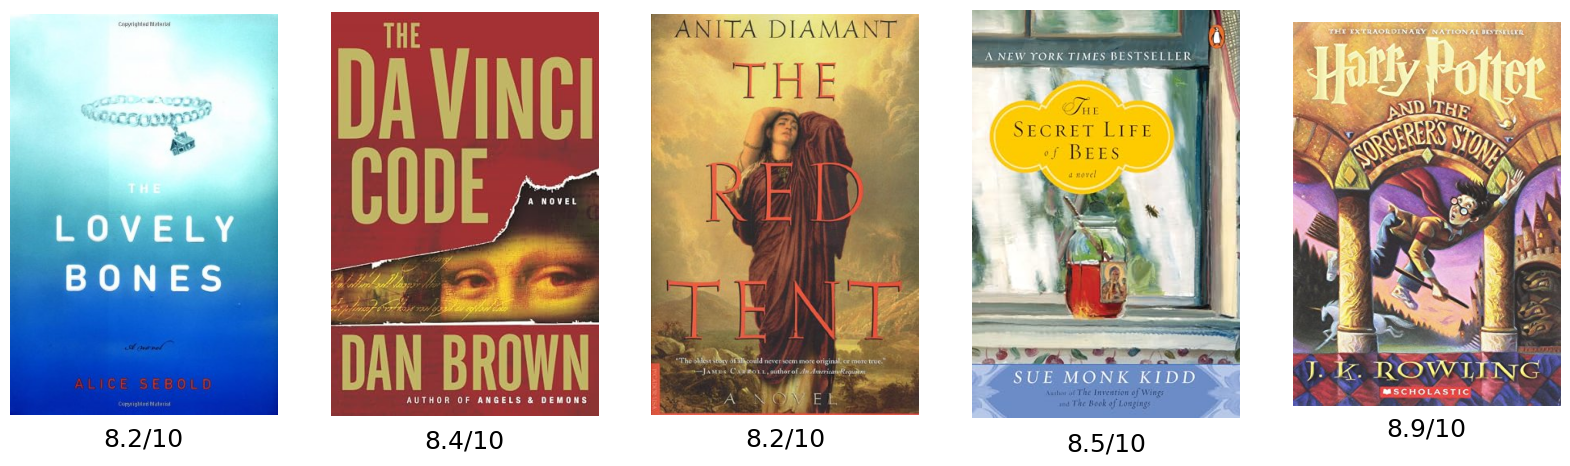

In [49]:
recommend_items_to_user(2651)

Top 5 recommendations for user 2655:
1. Venezianisches Finale. Commissario Brunettis erster Fall. by Donna Leon published in 1995
2. Harry Potter und die Kammer des Schreckens by Joanne K. Rowling published in 2000
3. Dear Doosie. by Werner Lansburgh published in 1977
4. Hilfe, die Herdmanns kommen. ( Ab 8 J.). by Barbara Robinson published in 1974
5. La Mort des bois by Brigitte Aubert published in 1998
----------------------------------------------------------------------------------------
Top favorite items for user 2655:
1. La Compagnia by Benni published in 1993


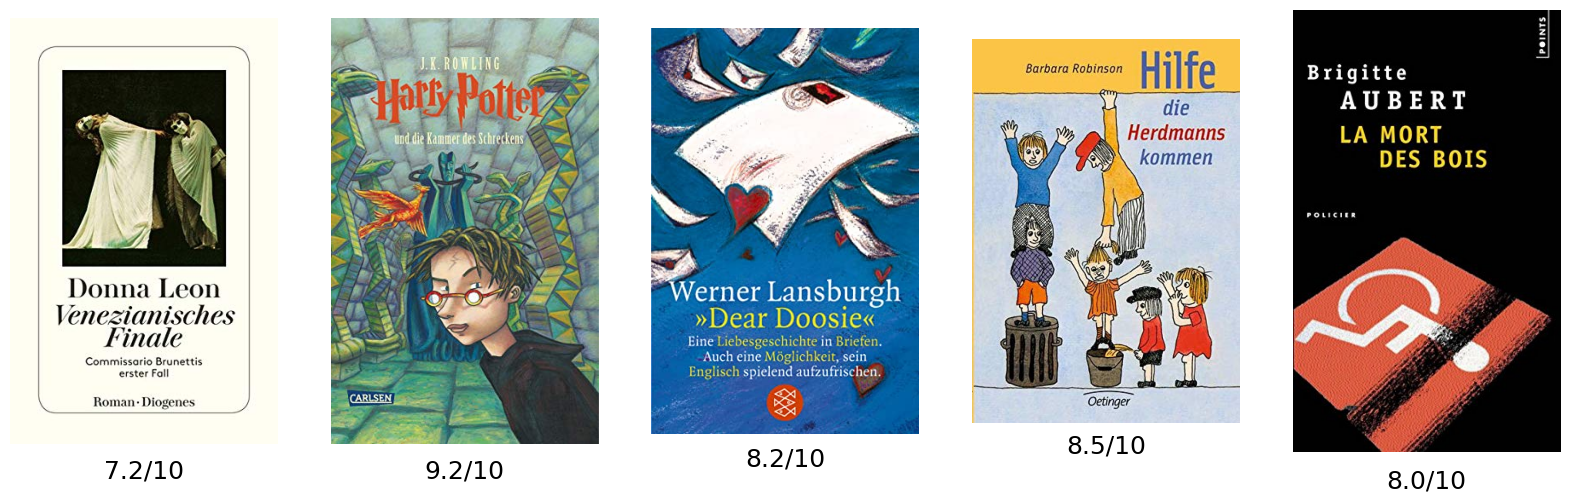

In [50]:
recommend_items_to_user(2655)

### Personalization Measurement

* Use Simpson Diversity Index to measure personalization
* The index ranges from 0 to 1 with higher value indicating more personalization

In [51]:
simpson_diversity_index = simpson_diversity_index()
print(f"Simpson Diversity Index: {simpson_diversity_index:.4f}")

Simpson Diversity Index: 0.9598


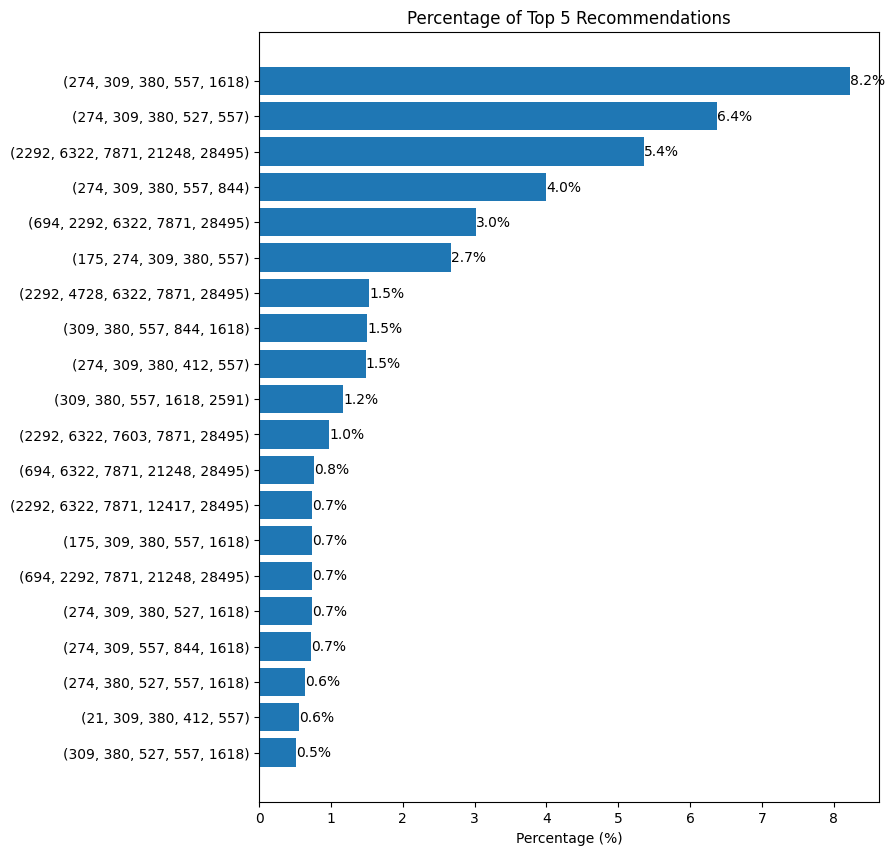

In [52]:
plot_scored_test_sample_combination_percentage_bar(top_n=20)